### Mexican Refugee Claim Outcomes at Canada's Immigration and Refugee Board

Author: Sean Rehaag

Date: March 1, 2024

Data Source: https://www.irb-cisr.gc.ca/en/statistics/protection/Pages/index.asp

Citation: Sean Rehaag, "Mexican Refugee Claim Outcomes at Canada's Immigration and Refugee Board" (1 March 2024) online: https://github.com/Refugee-Law-Lab/irb_web_stats/mexico_stats.ipynb

In [1]:
# Setup

#!pip install requests
#!pip install beautifulsoup4
#!pip install pandas

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt


### Load data

In [2]:
 # Get list of links to yearly RPD Stats

url = 'https://www.irb-cisr.gc.ca/en/statistics/protection/Pages/index.aspx'
url_domain = 'https://www.irb-cisr.gc.ca'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

links = []
for a in soup.find_all('a', href=True):
    if 'RPDStat' in a['href']:
        links.append(url_domain+a['href'])

In [3]:
# Load and clean data
df = pd.DataFrame()

for url in links:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find_all('table')[0]
    temp_df = pd.read_html(str(table))[0]

    temp_df.columns = temp_df.columns.droplevel(0)
    temp_df = temp_df.rename(columns={temp_df.columns[0]: 'Country'})
    temp_df.columns = list(temp_df.columns[:-1]) + ['Pending']
    temp_df.columns = temp_df.columns.str.replace('Withdrawn and Other', 'Withdrawn')
    temp_df.columns = temp_df.columns.str.replace('Withdrawn & Other', 'Withdrawn')
    temp_df.columns = temp_df.columns.str.replace('Total', 'Finalized')
    temp_df = temp_df.replace('--', 0)
    temp_df = temp_df.fillna(0)
    
    def clean_numbers(x):
        if type(x) == str:
            x = re.sub(r'[^\d]', '', x)
            if x == '':
                return 0
            else:
                return int(x)
        return int(x)

    for col in temp_df.columns:
        if col != 'Country':
            temp_df[col] = temp_df[col].apply(clean_numbers)

    temp_df = temp_df[~temp_df['Country'].str.contains('Total')]

    year = url.split('/')[-1].split('RPDStat')[1].split('.')[0]
    temp_df['Year'] = year

    cols = temp_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    temp_df = temp_df[cols]

    df = pd.concat([df, temp_df], ignore_index=True)

    print("Finished Year: ", year)
    

Finished Year:  2023
Finished Year:  2022
Finished Year:  2021
Finished Year:  2020
Finished Year:  2019
Finished Year:  2018
Finished Year:  2017
Finished Year:  2016
Finished Year:  2015
Finished Year:  2014
Finished Year:  2013


In [4]:
# Add recognition rate and abandoned or withdrawn rate

def add_rates(x_df):
    x_df['Recognition Rate'] = 100 * (x_df['Accepted'] / (x_df['Accepted'] + x_df['Rejected']))
    x_df['Abandoned or Withdrawn Rate'] = 100 * (x_df['Withdrawn']+ x_df['Abandoned']) / (x_df['Finalized'] + x_df['Pending'])

    # round rates
    x_df['Recognition Rate'] = x_df['Recognition Rate'].round(1)
    x_df['Abandoned or Withdrawn Rate'] = x_df['Abandoned or Withdrawn Rate'].round(1)
    
    # convert NAN to 0
    x_df = x_df.fillna(0)

    return x_df

df = add_rates(df)
df.head()

,Year,Country,Referred,Accepted,Rejected,Abandoned,Withdrawn,Finalized,Pending,Recognition Rate,Abandoned or Withdrawn Rate
0,2023,Afghanistan,3382,928,0,0,28,972,2836,100.0,0.7
1,2023,Albania,154,65,0,0,0,105,209,100.0,0.0
2,2023,Algeria,789,135,52,0,0,214,1011,72.2,0.0
3,2023,Angola,1051,162,100,0,0,286,1484,61.8,0.0
4,2023,Anguilla,0,0,0,0,0,0,0,0.0,0.0


### Analysis: Mexico

In [5]:
# years 2013 to 2016 do not have sufficient data
# and numbers are not reliable due to IRB
# small value suppression policy so drop them
# See: https://www.irb-cisr.gc.ca/en/statistics/Pages/small-value-suppression.aspx

mexico_df = df[df['Country'] == 'Mexico'].reset_index(drop=True)
mexico_df = mexico_df[mexico_df['Year'] >= '2017'].reset_index(drop=True)
mexico_df = mexico_df.sort_values('Year', ascending=True).reset_index(drop=True)
mexico_df

,Year,Country,Referred,Accepted,Rejected,Abandoned,Withdrawn,Finalized,Pending,Recognition Rate,Abandoned or Withdrawn Rate
0,2017,Mexico,1459,111,221,59,49,440,1221,33.4,6.5
1,2018,Mexico,3157,190,363,127,168,848,3525,34.4,6.7
2,2019,Mexico,5634,602,1045,288,384,2319,6829,36.6,7.3
3,2020,Mexico,2088,757,1119,94,354,2324,6607,40.4,5.0
4,2021,Mexico,3321,1236,1657,197,248,3338,6591,42.7,4.5
5,2022,Mexico,7483,1596,1796,319,305,4016,10045,47.1,4.4
6,2023,Mexico,25236,2894,2424,560,1240,7118,28165,54.4,5.1


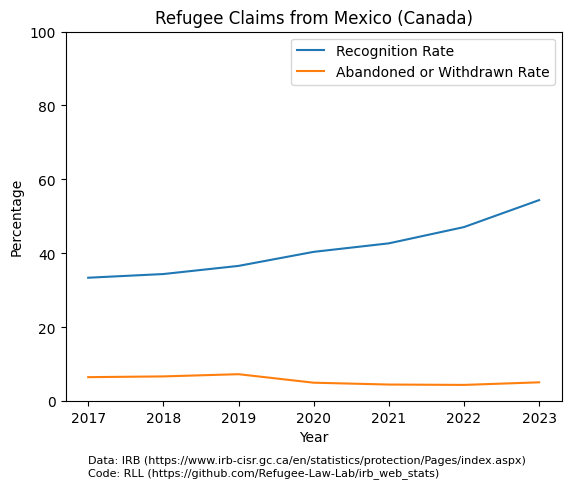

In [6]:
# Create Graph
mexico_df.plot(x='Year', y=['Recognition Rate', 'Abandoned or Withdrawn Rate'], kind='line', title='Refugee Claims from Mexico (Canada)', ylim=(0,100))

text_note = """Data: IRB (https://www.irb-cisr.gc.ca/en/statistics/protection/Pages/index.aspx)
Code: RLL (https://github.com/Refugee-Law-Lab/irb_web_stats)"""

plt.text(0, -20, text_note, fontsize=8, color='black')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.show()